# Collect the Observed Snow Data using CUAHSI Data Client

This noteook retrieves Snow Water Equivalent (SWE) and accumulated precipitation (P) data from SNOTEL sites through CUAHSI data client service.  The notebook has five sections as following:

1. Import Libraries
2. Visualize Ecoregions
3. Define Parameters
4. Define Functions 
5. Data Acquisition

## 1. Import Libraries
In this section, required python libraries are installed and imported.

In [3]:
import os
import ulmo
import pytz
import datetime
import rasterio as rio
from tzwhere import tzwhere
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib
import numpy as np
import pandas as pd
from pylab import *
import glob
import rasterio.mask
from matplotlib import colors
import matplotlib.image as mpimg
from osgeo import gdal, ogr, osr
from descartes import PolygonPatch
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon, MultiPolygon, shape
from geopandas import GeoSeries, GeoDataFrame, read_file, gpd

from datetime import datetime
from suds.client import Client
import matplotlib.pyplot as plt
from pandas import Grouper  
from datetime import timedelta
import matplotlib.dates as mdates

%matplotlib inline

## 2.   Visualize Ecoregions 
The study region is ased on 15 ecoregions provided by the Commission for Environmental Corporation (CEC) that has delineated these regions based on different facotrs including climate, vegetation, terrain, hydrology, wildlife, and land use.

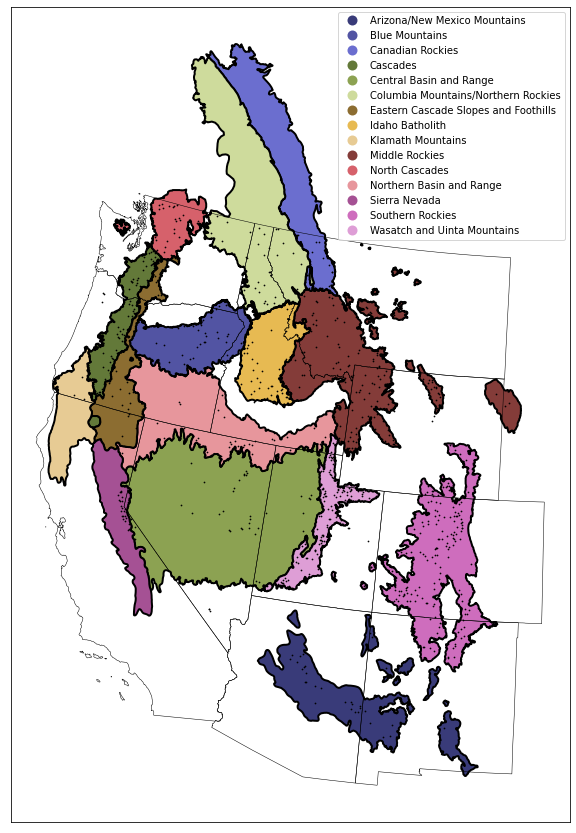

In [4]:
fig, axes = plt.subplots(figsize=(15, 15), ncols=1)

# Read data
cec_regions = gpd.read_file("../input/selected_CEC.shp", encoding="utf-8")
states = gpd.read_file("../input/Western_States.shp", encoding="utf-8")
snotel = gpd.read_file("../input/SNOTEL_w_CEC.shp", encoding="utf-8")

# Plot feature dataset
cec_regions.plot(column='NAME', ax=axes, cmap="tab20b", edgecolor='k', linewidths=2, legend=True)
states.plot(ax=axes, facecolor="none", edgecolor='black', linewidths=0.5)
snotel.plot(ax=axes, markersize=0.5, color='k')

# Format options
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [5]:
snotel_network = '../input/NRCS_SNOTEL_Joint_w_CEC.csv'
snotel_info = pd.read_csv(os.path.join(os.getcwd(), snotel_network))
snotel_info = snotel_info[snotel_info['Join_Count'] == 1]                 # To make sure only those associated with CEC are used

## 3.   Define Parameters

In [33]:
# Start preparing input arguments that are required when connecting to CUAHSI data client service
network = "SNOTEL"     
wsdl = f'http://hydroportal.cuahsi.org/{network.lower()}/cuahsi_1_1.asmx?WSDL'
client = Client(wsdl)

## 4.   Define Functions
Two functions are defined in this Jupyter Notebook. *DataFrame* and *Local2UTC*.  The first function is used to retrieve SNOTEL data.  The second function is used when we want to transform local time to UTC time.  

- DataFrame: This function retrieves the SNOTEL data from CUAHSI data client service and create a dataframe including retrieved information. 


- Locat2UTC: There are two different time zones within these ecoregions, Mountain Time and Pacific Time zones.  'America/Phoenix', is in the Mountain Time zone and does not observe daylight saving time.  It always has 7 hours offset from UTC.  'America/Boise' and 'America/Denver' are also in the Mountain Time zone with 6 hours offset from UTC during daylight saving time and 7 hours offset in standard time.  'America/Los_Angeles' is in the Pacific Time with 7 hours offset from UTC during daylight saving time and 8 hours ofset in standard time.  These are important when comparing daily average values of SNOTEL with hourly datasets such as NWM where outputs are in UTC time or SNODAS snapshots that are reported at 6:00 UTC.  The Local2UTC function takes a dataframe that has a column called 'date' (showing the local time for each record (row)) and a list of integer indices of the dataframe as inputs.  The function runs over each row of the dataframe and reads corresponding latitude and longitude values to get the name of the time zone ('America/Phoenix', America/Boise', 'America/Denver', or 'America/Los_Angeles').  Then, it uses pytz library and and transform the local date/time to a UTC date/time.  The next part checks for the offset value and updates the time for the local time that by default is 00:00:00.  This update helps to choose a time for SNOTEL local time that is equivalent to 6:00 UTC (as used in SNODAS outputs).

In [34]:
# Define a function to make a dataframe from retrieved data.  
# This function can be used for both SWE and Precipitation retrievals.

def DataFrame(self, st, et):
    
    # series info
    qo = self.queryInfo
    self.site_code = qo.criteria.locationParam
    self.variable_code = qo.criteria.variableParam
    self.start = st 
    self.end = et 

    # source info
    si = self.timeSeries[0].sourceInfo
    self.site_name = si.siteName
    self.latitude = si.geoLocation.geogLocation.latitude
    self.longitude = si.geoLocation.geogLocation.longitude
    
    # variable
    v = self.timeSeries[0].variable
    self.variable_name = v.variableName
    self.variable_datatype = v.dataType
    self.units_abbv = v.unit.unitAbbreviation
    self.nodata = v.noDataValue

    # values
    self.data = []
    for val in self.timeSeries[0].values[0].value:
        value_dt  = val._dateTime
        value_in = float(val.value)
        if value_in != self.nodata:
            value_mm = value_in * 25.4
        else:
            value_in = np.NaN
            value_mm = np.NaN
        self.data.append(dict(date=value_dt,
                              value_inches=value_in,
                              value_mm=value_mm))
     
    atts = {k:v for k,v in self.__dict__.items()}

    dat = []
    for val in self.data:
        content = {k:v for k,v in atts.items()}
        for k, v in val.items():
            content[k] = v
        dat.append(content)  

    df = pd.DataFrame(dat)
    df = df.set_index(df.date)
    return df

In [38]:
# Define a function that transform local time to UTC.

def Local2UTC(data, indices):
    
    from tzwhere import tzwhere
    tzwhere = tzwhere.tzwhere()

    LOCAL = []
    UTC = []
    
    # Loop over each row of the dataframe    
    for row in indices:
        timezone_str = tzwhere.tzNameAt(data.latitude[row], data.longitude[row])
        local_time = pytz.timezone(timezone_str)
        # The next line uses the date and by default gives the time 00:00:00 
        # (i.e., 12:00 am) to the datetime object
        naive_datetime = datetime.strptime(data['date'][row].strftime('%Y-%m-%d %H:%M:%S'), "%Y-%m-%d %H:%M:%S") 
        local_datetime = local_time.localize(naive_datetime, is_dst=None)
        utc_datetime = local_datetime.astimezone(pytz.utc)
        
        # Update naive_time based on timezone. This update helps to choose a 
        # time for SNOTEL daily values that are equivalent to 6:00 am UTC
        
        # Condition 1: if (local_time == "America/Phoenix") or 
        # (local_time == "America/Denver" and utc_datetime.hour == 7, Standard) or
        # (local_time == "America/Boise" and utc_datetime.hour == 7, Standard) or
        # (local_time == "America/Los_Angeles" and utc_datetime.hour == 7, Daylight)
        if utc_datetime.hour == 7:
            naive_datetime = naive_datetime + timedelta(hours=23)
            local_datetime = local_time.localize(naive_datetime, is_dst=None)
            utc_datetime = local_datetime.astimezone(pytz.utc)
            utc_datetime_str = utc_datetime.strftime ("%Y-%m-%d %H:%M:%S")
            
        # Condition 2: if (local_time == "America/Denver" and utc_datetime.hour == 6, Daylight) or
        # (local_time == "America/Boise" and utc_datetime.hour == 6, Daylight)
        elif utc_datetime.hour == 6: 
            naive_datetime = naive_datetime
            local_datetime = local_time.localize(naive_datetime, is_dst=None)
            utc_datetime = local_datetime.astimezone(pytz.utc)
            utc_datetime_str = utc_datetime.strftime ("%Y-%m-%d %H:%M:%S")
            
        # Condition 3: if (local_time == "America/Los_Angeles" and utc_datetime.hour == 8, Standard)
        elif utc_datetime.hour == 8: 
            naive_datetime = naive_datetime + timedelta(hours=22)
            local_datetime = local_time.localize(naive_datetime, is_dst=None)
            utc_datetime = local_datetime.astimezone(pytz.utc)
            utc_datetime_str = utc_datetime.strftime ("%Y-%m-%d %H:%M:%S")
            
        
        LOCAL.append(local_datetime)
        UTC.append(utc_datetime_str)
        
        
    # Add columns to the dataframe
    data['datetime_LOCAL'] = LOCAL
    data['datetime_UTC'] = UTC
        
    # Add UTC times to index
    data.index = data['datetime_UTC']

    return data


In [40]:
# Print Ecoregion Names
for cec_name in set(cec_regions['NAME']):
    print(cec_name)

Canadian Rockies
Northern Basin and Range
Eastern Cascade Slopes and Foothills
Arizona/New Mexico Mountains
Southern Rockies
Idaho Batholith
Columbia Mountains/Northern Rockies
Central Basin and Range
Klamath Mountains
Cascades
Middle Rockies
Blue Mountains
North Cascades
Wasatch and Uinta Mountains
Sierra Nevada


## 5.   Data Acquisition


In [39]:
for cec_name in set(cec_regions['NAME']):  
       
    # Select data for a region and print the number of snotel gages within this domain
    snotel_Region = snotel_info[snotel_info['NAME'] == cec_name]
    snotel_Region.reset_index(drop=True, inplace=True)
    print("There are ", snotel_Region.shape[0], " SNOTEL gages within ", cec_name)
        
    # Create empty arrays to store data
    code = []
    site_code = []
    site = []
    
    for c in range(0, snotel_Region.shape[0]):
        try:
            cd = f'{snotel_Region["Station_ID"][c]}_{snotel_Region["State"][c]}_SNTL'
            sc = f'{network}:{cd}'
            st = ulmo.cuahsi.wof.get_site_info(wsdl, sc, suds_cache=('default', ))

            code.append(cd)
            site_code.append(sc)
            site.append(st)
        except Exception as error:
            print("========================================")
            print(cd, f'with index {c} cannot be retrieved.')
            print("========================================")
            pass
        
    # Read Snow Water Equivalent (SWE) where WTEQ_D is daily and WTEQ_H is hourly data.
    variable_code_daily = f'{network}:WTEQ_D'
    swe_Daily = pd.DataFrame([])
    
    for i in range(0,len(site_code)):
        sc = f'{network}:{site[i]["code"]}'
        st = datetime.strptime(site[i]['site_property']['site_comments'].split('|')[0].split('=')[1].split(' ')[0], '%m/%d/%Y')
        et = datetime.strptime(site[i]['site_property']['site_comments'].split('|')[1].split('=')[1].split(' ')[0], '%m/%d/%Y')
        
        try:
            swe_temp = client.service.GetValuesObject(sc, variable_code_daily, st, et, '')
            swe_temp_df = DataFrame(swe_temp, st, et)
            swe_Daily = swe_Daily.append(swe_temp_df, ignore_index=True)
            print(i, sc, st, et)  
        except Exception as error:
            print("==========================================================")
            print(f'SWE at {sc} with index {i} in site_code is not available.')
            print("==========================================================")
            pass
        
    # Read Cumulative Precipitation where PREC_D is daily and PREC_H hourly accumulated precipitation data.
    variable_code_daily = f'{network}:PREC_D'
    precip_Daily = pd.DataFrame([])

    for i in range(0,len(site_code)):
        sc = f'{network}:{site[i]["code"]}'
        st = datetime.strptime(site[i]['site_property']['site_comments'].split('|')[0].split('=')[1].split(' ')[0], '%m/%d/%Y')
        et = datetime.strptime(site[i]['site_property']['site_comments'].split('|')[1].split('=')[1].split(' ')[0], '%m/%d/%Y')
        
        try:
            precip_temp = client.service.GetValuesObject(sc, variable_code_daily, st, et, '')
            precip_temp_df = DataFrame(precip_temp, st, et)
            precip_Daily = precip_Daily.append(precip_temp_df, ignore_index=True)
            print(i, sc, st, et) 
        except Exception as error:
            print("====================================================================")
            print(f'Precipitation at {sc} with index {i} in site_code is not available.')
            print("====================================================================")
            pass 
        
    # It is better to have separate dataframes since the length of SWE and Precipitation values may not be the same.
    swe_Daily_small_df = pd.DataFrame({'col1':swe_Daily['site_code'], 
                                       'col2':swe_Daily['site_name'], 
                                       'col3':swe_Daily['date'], 
                                       'col4':swe_Daily['value_inches'],
                                       'col5':swe_Daily['value_mm'],
                                       'col6':swe_Daily['latitude'],
                                       'col7':swe_Daily['longitude']}) 
    swe_Daily_small_df['name']= cec_name
    swe_Daily_small_df.columns = ['site_code', 'site_name', 'date', 'swe_inches', 'swe_mm', 'latitude', 'longitude', 'name']
    

    precip_Daily_small_df = pd.DataFrame({'col1':precip_Daily['site_code'], 
                                          'col2':precip_Daily['site_name'], 
                                          'col3':precip_Daily['date'], 
                                          'col4':precip_Daily['value_inches'],
                                          'col5':precip_Daily['value_mm'], 
                                          'col6':precip_Daily['latitude'], 
                                          'col7':precip_Daily['longitude']})  
    precip_Daily_small_df['name']= cec_name
    precip_Daily_small_df.columns = ['site_code', 'site_name', 'date', 'precip_inches', 'precip_mm', 'latitude', 'longitude', 'name']

    
    # Run Local2UTC function
    swe_Daily_small_df_utc = Local2UTC(swe_Daily_small_df, swe_Daily_small_df.index)
    precip_Daily_small_df_utc = Local2UTC(precip_Daily_small_df, precip_Daily_small_df.index)

    
    # Save results as a CSV file.
    cec_name = cec_name.replace(" ","")
    cec_name = cec_name.replace("/","")
    swe_Daily_small_df_utc.to_csv(f'../output/SNOTEL_at_{cec_name}_SWE.csv', index=False)
    precip_Daily_small_df_utc.to_csv(f'../output/SNOTEL_at_{cec_name}_P.csv', index=False)
    
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    

There are  29  SNOTEL gages within  Sierra Nevada
0 SNOTEL:340_NV_SNTL 1983-10-01 00:00:00 2100-01-01 00:00:00
1 SNOTEL:356_CA_SNTL 1980-10-01 00:00:00 2100-01-01 00:00:00
2 SNOTEL:1051_CA_SNTL 2003-10-01 00:00:00 2100-01-01 00:00:00
3 SNOTEL:1067_CA_SNTL 2004-10-01 00:00:00 2100-01-01 00:00:00
4 SNOTEL:428_CA_SNTL 1980-10-01 00:00:00 2100-01-01 00:00:00
5 SNOTEL:462_CA_SNTL 1978-10-01 00:00:00 2100-01-01 00:00:00
6 SNOTEL:463_CA_SNTL 1980-10-01 00:00:00 2100-01-01 00:00:00
7 SNOTEL:473_CA_SNTL 1979-10-01 00:00:00 2100-01-01 00:00:00
8 SNOTEL:1049_CA_SNTL 2003-10-01 00:00:00 2100-01-01 00:00:00
9 SNOTEL:508_CA_SNTL 1978-10-01 00:00:00 2100-01-01 00:00:00
10 SNOTEL:518_CA_SNTL 1978-10-01 00:00:00 2100-01-01 00:00:00
11 SNOTEL:1050_CA_SNTL 2003-10-10 00:00:00 2100-01-01 00:00:00
12 SNOTEL:539_CA_SNTL 1978-10-01 00:00:00 2100-01-01 00:00:00
13 SNOTEL:540_CA_SNTL 1980-10-01 00:00:00 2100-01-01 00:00:00
14 SNOTEL:541_CA_SNTL 1978-10-01 00:00:00 2100-01-01 00:00:00
15 SNOTEL:574_CA_SNTL 1989

## 6.   Combine Results

In [6]:
snotel_info.groupby(['NAME']).size()

NAME
Arizona/New Mexico Mountains             31
Blue Mountains                           30
Canadian Rockies                         16
Cascades                                 65
Central Basin and Range                  39
Columbia Mountains/Northern Rockies      33
Eastern Cascade Slopes and Foothills     22
Idaho Batholith                          38
Klamath Mountains                         3
Middle Rockies                          140
North Cascades                           30
Northern Basin and Range                 37
Sierra Nevada                            29
Southern Rockies                        159
Wasatch and Uinta Mountains             114
dtype: int64

In [7]:
output_path = "/uufs/chpc.utah.edu/common/home/ci-water6-1/igarousi/SNOTEL/output"

for f in glob.glob(os.path.join(output_path, '*P.csv')):
    data = pd.read_csv(f)
    print(set(data['name']), len(set(data['site_code'])))


{'Canadian Rockies'} 16
{'Northern Basin and Range'} 35
{'Eastern Cascade Slopes and Foothills'} 22
{'Arizona/New Mexico Mountains'} 31
{'Southern Rockies'} 159
{'Idaho Batholith'} 38
{'Columbia Mountains/Northern Rockies'} 33
{'Central Basin and Range'} 38
{'Klamath Mountains'} 3
{'Cascades'} 65
{'Middle Rockies'} 140
{'Blue Mountains'} 30
{'North Cascades'} 30
{'Wasatch and Uinta Mountains'} 112
{'Sierra Nevada'} 29


In [8]:
output_path = "/uufs/chpc.utah.edu/common/home/ci-water6-1/igarousi/SNOTEL/output"

Data=pd.DataFrame([])

for f in glob.glob(os.path.join(output_path, '*P.csv')):
    data = pd.read_csv(f)
    frames = [Data, data]
    Data = pd.concat(frames, ignore_index=True)

Data.to_csv(os.path.join(output_path, 'SNOTEL_P.csv'))


In [9]:
output_path = "/uufs/chpc.utah.edu/common/home/ci-water6-1/igarousi/SNOTEL/output"

Data=pd.DataFrame([])

for f in glob.glob(os.path.join(output_path, '*SWE.csv')):
    data = pd.read_csv(f)
    frames = [Data, data]
    Data = pd.concat(frames, ignore_index=True)

Data.to_csv(os.path.join(output_path, 'SNOTEL_SWE.csv'))
